词频统计和词云图展示 词性标注 关键词提取 文本聚类

1.词频统计和词云图展示

In [1]:
# 导入库
import numpy as np  # numpy库
import collections  # 词频统计库
import re  # 正则表达式库
import jieba  # 结巴分词
import wordcloud  # 词云展示库
from PIL import Image  # 图像处理库
import matplotlib.pyplot as plt  # 图像展示库

# 读取文本文件
fn = open('article1.txt')  # 以只读方式打开文件
string_data = fn.read()  # 使用read方法读取整段文本
fn.close()  # 关闭文件对象

In [2]:
# 文本预处理
pattern = re.compile(u'\t|\n|\.|-|一|:|;|\)|\(|\?|"')  # 建立正则表达式匹配模式
string_data = re.sub(pattern, '', string_data)  # 将符合模式的字符串替换掉

# 文本分词
seg_list_exact = jieba.cut(string_data, cut_all=False)  # 精确模式分词[默认模式]
remove_words = ['的', '，', '和', '是', '随着', '对于', ' ', '对', '等', '能', '都', '。',
                '、', '中', '与', '在', '其', '了', '可以', '进行', '有', '更', '需要', '提供',
                '多', '能力', '通过', '会', '不同', '一个', '这个', '我们', '将', '并',
                '同时', '看', '如果', '但', '到', '非常', '—', '如何', '包括', '这']  # 自定义去除词库
object_list = [i for i in seg_list_exact if i not in remove_words] # 将不在去除词列表中的词添加到列表中

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\pr\AppData\Local\Temp\jieba.cache
Loading model cost 0.849 seconds.
Prefix dict has been built successfully.


In [3]:
# 词频统计
word_counts = collections.Counter(object_list)  # 对分词做词频统计
word_counts_top5 = word_counts.most_common(5)  # 获取前5个频率最高的词
for w, c in word_counts_top5:  # 分别读出每条词和出现的次数
    print(w, c)  

数据 113
分析 48
功能 47
Adobe 45
Analytics 37


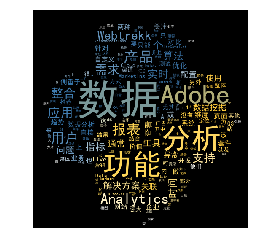

In [4]:
# 词频展示
mask = np.array(Image.open('wordcloud.jpg'))  # 定义词频背景
wc = wordcloud.WordCloud(
    font_path='simhei.ttf',  # 设置字体格式，不设置将无法显示中文
    mask=mask,  # 设置背景图
    max_words=200,  # 设置最大显示的词数
    max_font_size=100  # 设置字体最大值
)
wc.generate_from_frequencies(word_counts)  # 从字典生成词云
image_colors = wordcloud.ImageColorGenerator(mask)  # 从背景图建立颜色方案
wc.recolor(color_func=image_colors)  # 将词云颜色设置为背景图方案
plt.imshow(wc)  # 显示词云
plt.axis('off')  # 关闭坐标轴
plt.show()  # 显示图像

2.词性标注

In [5]:
# 导入库
import pandas as pd
import jieba.posseg as pseg

# 读取文本文件
fn = open('article1.txt')  # 以只读方式打开文件
string_data = fn.read()  # 使用read方法读取整段文本
fn.close()  # 关闭文件对象

In [6]:
# 分词+词性标注
words = pseg.cut(string_data)  # 分词
words_list = []  # 空列表用于存储分词和词性分类
for word in words:  # 循环得到每个分词
    words_list.append((word.word, word.flag))  # 将分词和词性分类追加到列表
words_pd = pd.DataFrame(words_list, columns=['word', 'type'])  # 创建结果数据框
print(words_pd.head(4))  

word type
0      Adobe  eng
1               x
2  Analytics  eng
3          和    c


In [7]:
# 词性分类汇总-两列分类
words_gb = words_pd.groupby(['type', 'word'])['word'].count()
print(words_gb.head(4))

# 词性分类汇总-单列分类
words_gb2 = words_pd.groupby('type').count()
words_gb2 = words_gb2.sort_values(by='word', ascending=False)
print(words_gb2.head(4))

# 选择特定类型词语做展示
words_pd_index = words_pd['type'].isin(['n', 'eng'])
words_pd_select = words_pd[words_pd_index]
print(words_pd_select.head(4))

type  word
a     不同      14
      不足       2
      不通       1
      严谨       2
Name: word, dtype: int64
      word
type      
x      994
n      981
v      834
eng    295
        word type
0      Adobe  eng
2  Analytics  eng
4   Webtrekk  eng
9         领域    n


3.关键字提取

In [8]:
# 导入库
import pandas as pd  
import jieba.analyse  # 导入关键字提取库

# 读取文本数据
fn = open('article1.txt')  # 以只读方式打开文件
string_data = fn.read()  # 使用read方法读取整段文本
fn.close()  # 关闭文件对象

In [9]:
# 关键字提取
tags_pairs = jieba.analyse.extract_tags(string_data, topK=5, withWeight=True,allowPOS=['ns', 'n', 'vn', 'v', 'nr'],withFlag=True)  # 提取关键字标签
tags_list = []  # 空列表用来存储拆分后的三个值
for i in tags_pairs:  # 打印标签、分组和TF-IDF权重
    tags_list.append((i[0].word, i[0].flag, i[1]))  
tags_pd = pd.DataFrame(tags_list, columns=['word', 'flag', 'weight'])  # 创建数据框
print(tags_pd)  

word flag    weight
0   数据    n  0.313395
1   报表    n  0.163367
2   功能    n  0.150263
3   分析   vn  0.134857
4   用户    n  0.126633


4.文本聚类

In [10]:
# 导入库
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer  # 基于TF-IDF的词频转向量库
import jieba.posseg as pseg
from sklearn.cluster import KMeans

# 中文分词
def jieba_cut(comment):
    seg_list = pseg.cut(comment)  # 精确模式分词[默认模式]
    word_list = [i.word for i in seg_list if i.flag in ['a', 'ag', 'an']] # 只选择形容词追加到列表中
    return word_list

In [11]:
# 读取数据文件
fn = open('comment1.txt',encoding='utf8')
comment_list = fn.readlines()  # 读取文件内容为列表
fn.close()

In [12]:
# word to vector
stop_words = ['…', '。', '，', '？', '！', '+', ' ', '、', '：', '；', '（', '）', '.', '-']  # 定义停用词
vectorizer = TfidfVectorizer(stop_words=stop_words, tokenizer=jieba_cut, use_idf=True)  # 创建词向量模型
X = vectorizer.fit_transform(comment_list)  # 将评论关键字列表转换为词向量空间模型

# K均值聚类
model_kmeans = KMeans(n_clusters=3)  # 创建聚类模型对象
model_kmeans.fit(X)  # 训练模型
cluster_labels = model_kmeans.labels_  # 聚类标签结果

word_vectors = vectorizer.get_feature_names()  # 词向量
word_values = X.toarray()  # 向量值
comment_matrix = np.hstack(
    (word_values, cluster_labels.reshape(word_values.shape[0], 1)))  # 将向量值和标签值合并为新的矩阵
word_vectors.append('cluster_labels')  # 将新的聚类标签列表追加到词向量后面
comment_pd = pd.DataFrame(comment_matrix, columns=word_vectors)  # 创建包含词向量和聚类标签的数据框
print(comment_pd.head(1))  # 打印输出数据框第1条数据

# 聚类结果分析
comment_cluster1 = comment_pd[comment_pd['cluster_labels'] == 2].drop('cluster_labels',axis=1)  # 选择聚类标签值为2的数据，并删除最后一列
word_importance = np.sum(comment_cluster1, axis=0)  # 按照词向量做汇总统计
print(word_importance.sort_values(ascending=False)[:5])  # 按汇总统计的值做逆序排序并打印输出前5个词


一般   不厚   不爽   不贵   不错   不高   便宜   具体   准确    凹       ...          蓝   诚意  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       ...        0.0  0.0   

     贵    足   透亮   重要    难         高   麻烦  cluster_labels  
0  0.0  0.0  0.0  0.0  0.0  0.392535  0.0             0.0  

[1 rows x 64 columns]
好     8.074925
流畅    1.609872
一般    1.482828
大     1.126262
清晰    1.069721
dtype: float64
